In [1]:
from phoenix.selfconsistency import adam_optimizer_spheroid
from phoenix.potentials import plummer_potential

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
params = {
    "R0": 8.0, # for actions to phase space
    "N0_spheroid": 1e6,
    "J0_spheroid": 1000.0,
    "Gamma_spheroid": 2.5,
    "Beta_spheroid": 3.5,
}

envelope_max = 3.0
n_candidates = 250_000
key = jax.random.PRNGKey(42)

Phi_spheroid = plummer_potential
theta_spheroid = jnp.array([1e12, 10.0]) # (M, a) z.B. für Plummer

In [3]:
r_min = 0
r_max = 10
z_min = -5
z_max = 5
rbin = jnp.linspace(r_min, r_max, 20)
zbin = jnp.linspace(z_min, z_max, 20)

In [ ]:
learning = 5e-2
theta_opt, loss_hist, theta_hist = adam_optimizer_spheroid(key, params, Phi_spheroid, theta_spheroid, n_candidates, 
                                                           envelope_max, rbin, zbin, learning, num_iterations=3000)

Iteration 0, Loss: 8330837504.0000, Theta: [9.5123053e+11 1.0512709e+01]
Iteration 100, Loss: 24038360.0000, Theta: [4.0904812e+11 2.4823328e+01]


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_results(loss_history, theta_history):
    # Convert lists to numpy arrays
    loss_history = np.array(loss_history)
    theta_history = np.array(theta_history)  # Shape: (iterations, 2)

    # Create 3 subplots side-by-side
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Loss History (Log Scale)
    ax[0].plot(loss_history, color='black', lw=1.5)
    ax[0].set_yscale('log')
    ax[0].set_title("Total Loss Convergence", fontsize=14)
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Loss")
    ax[0].grid(True, which="both", ls="-", alpha=0.15)

    # 2. Theta 1 Evolution
    ax[1].plot(theta_history[:, 0], color='tab:blue', lw=2)
    ax[1].set_title(r"Parameter $\theta_1$: Mass", fontsize=14)
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("Value")
    ax[1].grid(True, alpha=0.2)

    # 3. Theta 2 Evolution
    ax[2].plot(theta_history[:, 1], color='tab:orange', lw=2)
    ax[2].set_title(r"Parameter $\theta_2: a$", fontsize=14)
    ax[2].set_xlabel("Iteration")
    ax[2].set_ylabel("Value")
    ax[2].grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

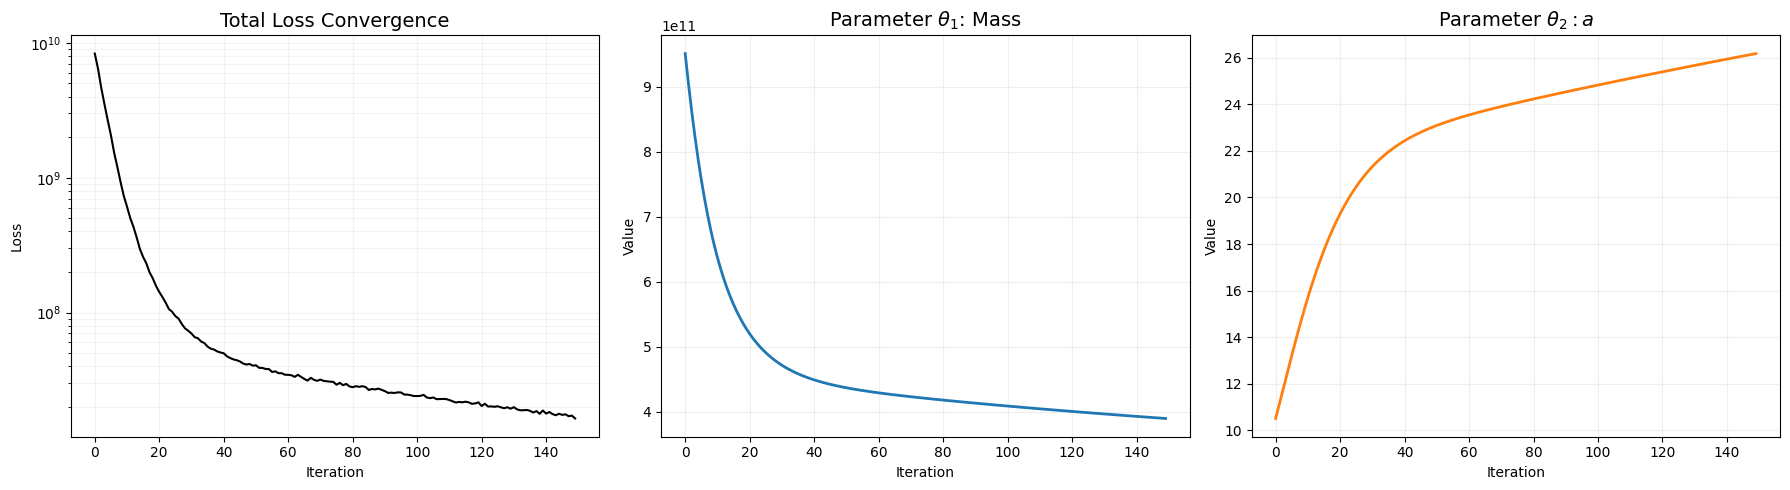

In [6]:
plot_training_results(loss_hist, theta_hist)

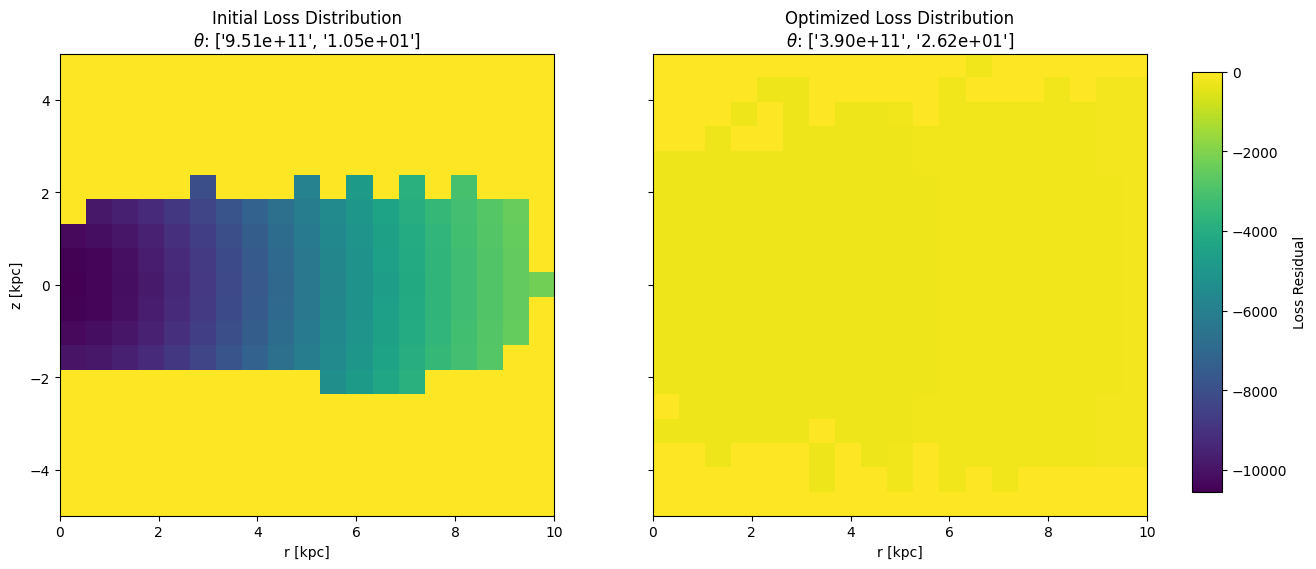

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from phoenix.selfconsistency import compute_loss

initial_lp = compute_loss(key, params, Phi_spheroid, theta_hist[0], n_candidates, envelope_max, rbin, zbin)
final_lp = compute_loss(key, params, Phi_spheroid, theta_hist[-1], n_candidates, envelope_max, rbin, zbin)

vmin = min(np.nanmin(initial_lp), np.nanmin(final_lp))
vmax = max(np.nanmax(initial_lp), np.nanmax(final_lp))

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Common settings for imshow
im_kwargs = {
    'origin': 'lower',
    'aspect': 'auto',
    'extent': [r_min, r_max, z_min, z_max],
    'cmap': 'viridis',
    'vmin': vmin,
    'vmax': vmax
}

# Left Plot: Initial
im0 = axes[0].imshow(initial_lp.T, **im_kwargs)
axes[0].set_title(f'Initial Loss Distribution\n' + r'$\theta$: ' + f'{[f"{t:.2e}" for t in theta_hist[0]]}')
axes[0].set_xlabel('r [kpc]')
axes[0].set_ylabel('z [kpc]')

# Right Plot: Optimized
im1 = axes[1].imshow(final_lp.T, **im_kwargs)
axes[1].set_title(f'Optimized Loss Distribution\n' + r'$\theta$: ' + f'{[f"{t:.2e}" for t in theta_hist[-1]]}')
axes[1].set_xlabel('r [kpc]')

# Add one shared colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax, label='Loss Residual')

plt.show()

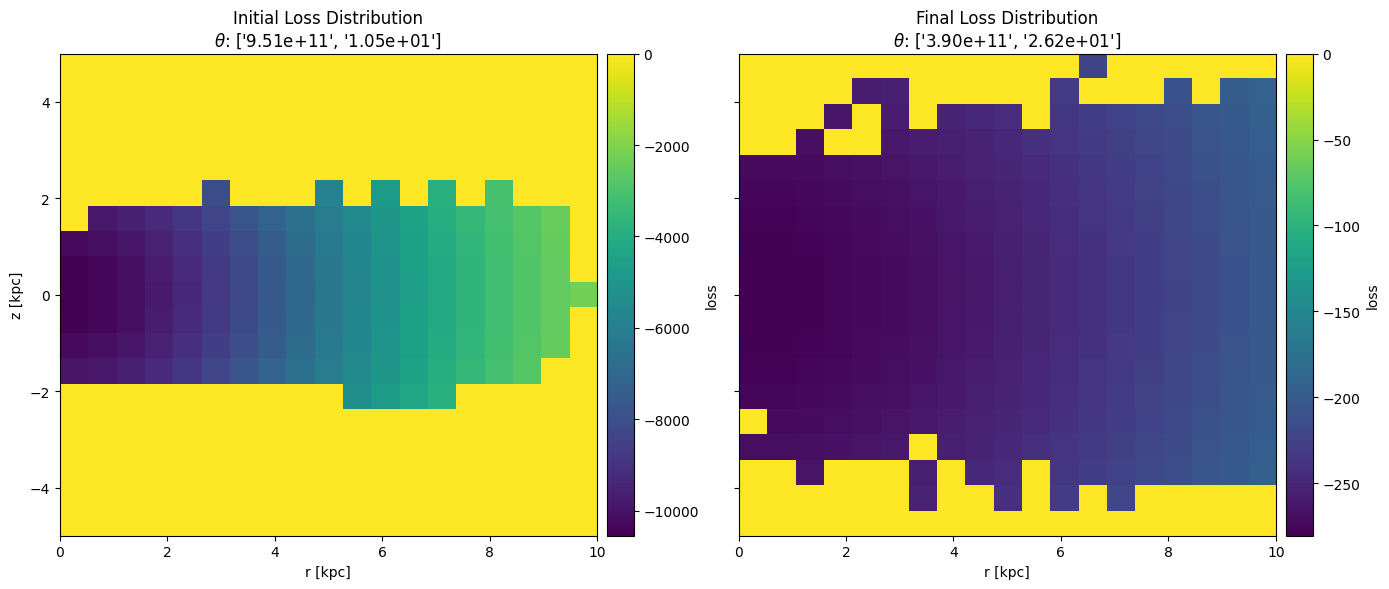

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Define common imshow parameters
im_kwargs = {
    'origin': 'lower',
    'aspect': 'auto',
    'extent': [r_min, r_max, z_min, z_max],
    'cmap': 'viridis'
}

# --- Left Plot: Initial ---
im0 = axes[0].imshow(initial_lp.T, **im_kwargs)
axes[0].set_title(f'Initial Loss Distribution\n' + r'$\theta$: ' + f'{[f"{t:.2e}" for t in theta_hist[0]]}')
axes[0].set_xlabel('r [kpc]')
axes[0].set_ylabel('z [kpc]')

# Create individual colorbar for the left plot
divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im0, cax=cax0, label='loss')

# --- Right Plot: Final ---
im1 = axes[1].imshow(final_lp.T, **im_kwargs)
axes[1].set_title(f'Final Loss Distribution\n' + r'$\theta$: ' + f'{[f"{t:.2e}" for t in theta_hist[-1]]}')
axes[1].set_xlabel('r [kpc]')

# Create individual colorbar for the right plot
divider1 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1, cax=cax1, label='loss')

plt.tight_layout()
plt.show()

In [9]:
from phoenix.distributionfunctions_spheroidal import f_double_power_law
from phoenix.selfconsistency import compute_density_jax
from phoenix import sampling, actions_to_phase_space

def get_density_and_mask(f_double_power_law, key, params, Phi, theta, n_candidates, envelope_max, rbin, zbin):

    candidates, samples, soft_weights = sampling.sample_df_potential(
        f_double_power_law, key, params, Phi, theta, n_candidates, envelope_max, tau=0.01
    )

    phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(
        samples, params, key, Phi, theta
    )

    x = phase_space_coords[:, 0]
    y = phase_space_coords[:, 1]
    z = phase_space_coords[:, 2]

    density, mask = compute_density_jax(x, y, z, soft_weights, r_bins=rbin, z_bins=zbin)
    
    return density, mask

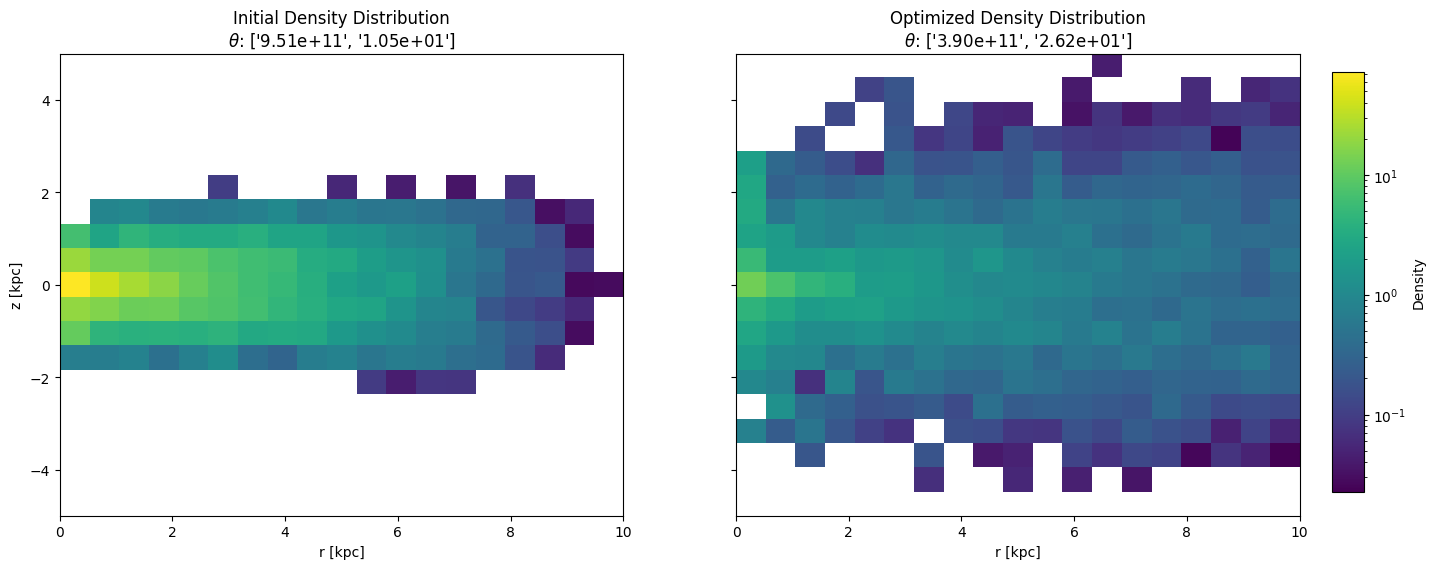

In [10]:
initial_density, mask_initial = get_density_and_mask(f_double_power_law, key, params, Phi_spheroid, theta_hist[0], n_candidates, envelope_max, rbin, zbin)
final_density, mask_final = get_density_and_mask(f_double_power_law, key, params, Phi_spheroid, theta_hist[-1], n_candidates, envelope_max, rbin, zbin)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
extent = [r_min, r_max, z_min, z_max]

combined_vals = np.concatenate([initial_density.flatten(), final_density.flatten()])
vmin = np.nanmin(combined_vals[combined_vals > 0])
vmax = np.nanmax(combined_vals)
shared_norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# Initial Plot
im0 = axes[0].imshow(initial_density.T, origin='lower', aspect='auto',
                     extent=extent, cmap='viridis', norm=shared_norm)
axes[0].set_title(f'Initial Density Distribution\n$\\theta$: {[f"{t:.2e}" for t in theta_hist[0]]}')
axes[0].set_xlabel('r [kpc]')
axes[0].set_ylabel('z [kpc]')

# Optimized Plot
im1 = axes[1].imshow(final_density.T, origin='lower', aspect='auto',
                     extent=extent, cmap='viridis', norm=shared_norm)
axes[1].set_title(f'Optimized Density Distribution\n$\\theta$: {[f"{t:.2e}" for t in theta_hist[-1]]}')
axes[1].set_xlabel('r [kpc]')

fig.subplots_adjust(right=0.9) # Make room for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
fig.colorbar(im1, cax=cbar_ax, label='Density')

plt.show()